<a href="https://colab.research.google.com/github/paarthbamb/CyberPatriotStuff/blob/main/Unit4/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
cs_data


,ID,aa,theo,exp,diff_TminusE,cat
0,1BM8,ILE,61.18,58.27,2.91,Non-Polar
1,1BM8,TYR,56.95,56.18,0.77,Polar
2,1BM8,SER,56.35,56.84,-0.49,Polar
3,1BM8,ALA,51.96,51.01,0.95,Special
4,1BM8,ARG,56.54,54.64,1.90,Charged
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72,Charged
1772,1KS9,ARG,58.91,59.02,-0.11,Charged
1773,1KS9,LYS,59.49,58.92,0.57,Charged
1774,1KS9,GLU,59.48,58.36,1.12,Charged


In [ ]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode
aa_idx = aa_encode.codes
aa_idx
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model: # StudentT priors and likelihood
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu = 30)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu = 30)
    μ_nm = pm.HalfStudentT('μ_nm', sigma = 10, nu = 30)

    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  nu = μ_nm,
                  dims = "aa")

    σ = pm.HalfStudentT('σ',
                        sigma = 10,
                        nu = 30,
                        dims = "aa")
    ν = pm.HalfStudentT('ν',
                        sigma = 10,
                        nu = 30,
                        dims = "aa")

    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = ν[aa_idx],
                  observed = cs_data.diff_TminusE)

    idata_cs_h = pm.sample()

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model2: # Normal priors and likelihoods
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    idata_cs_h2 = pm.sample()


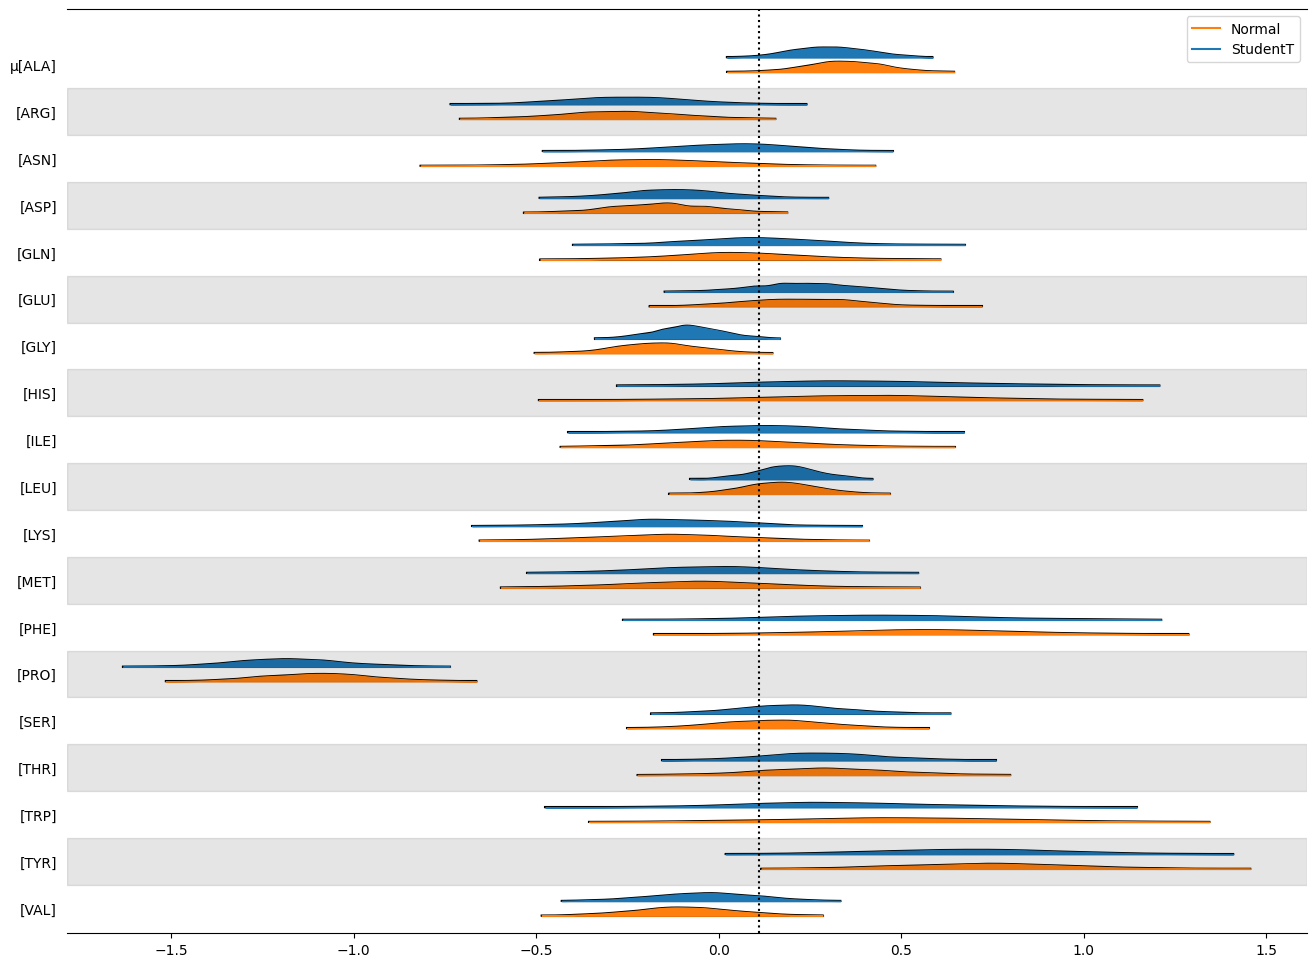

In [ ]:
axes = az.plot_forest([idata_cs_h, idata_cs_h2], kind="ridgeplot", model_names=['StudentT', 'Normal'], var_names='μ', combined=True, figsize=(16, 12),hdi_prob=0.997)
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

StudentT matches better for almost all the amino acids.

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

(-15.0, 15.0)

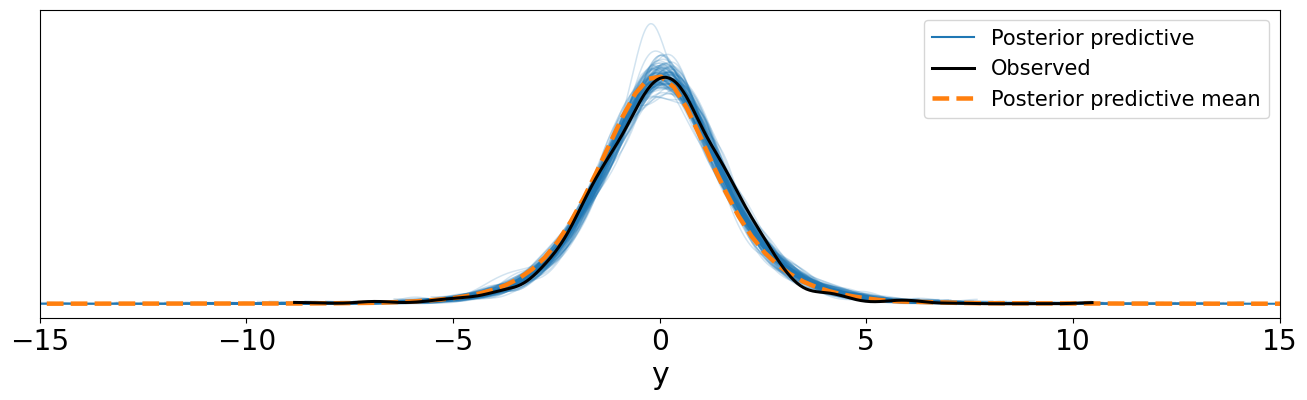

In [ ]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)

ax = az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(16, 4))
ax.set_xlim(-15,15)

Output()

(-15.0, 15.0)

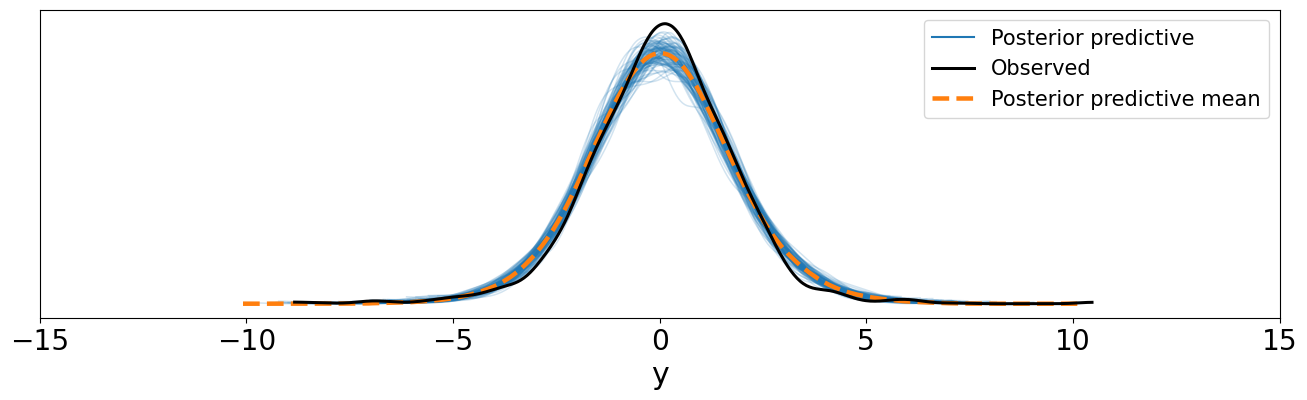

In [ ]:
pm.sample_posterior_predictive(idata_cs_h2, model=cs_h_model2, extend_inferencedata=True)
ax = az.plot_ppc(idata_cs_h2, num_pp_samples=100, figsize=(16, 4))
ax.set_xlim(-15,15)



StudentT fits better especially at the top, and also fits the side better with a more representative stdev.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [ ]:
pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

with pm.Model(coords = sccr_coords) as sccr_model_nh:
    μ_p = pm.Beta('μ_p', mu = 1/11, nu = 55, dims = "pos")
    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])
    _ = pm.Binomial('gs', n = sccr_data.shots.values, p = θ, observed = sccr_data.goals.values)
    idata_sccr_nh = pm.sample(target_accept = 0.95)

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 0.9995 1.003 1.0 ... 1.001 1.002 0.9996
    μ_p      (pos) float64 32B 1.002 1.002 1.026 1.002
    ν_p      (pos) float64 32B 1.006 1.001 1.445 1.004

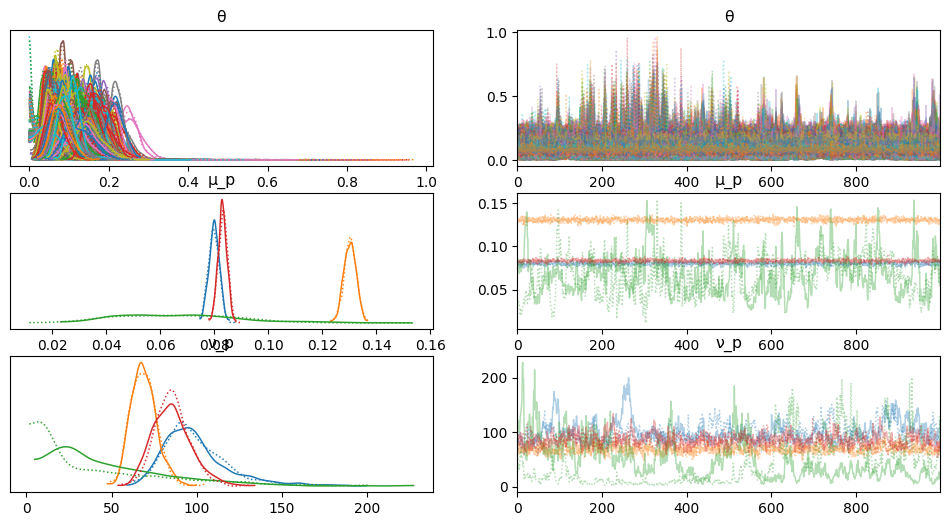

In [13]:
az.plot_trace(idata_sccr_nh)
az.rhat(idata_sccr_nh)

The non-hierarchical model didn't converge as well as the hierarchical one, especially for ν_p. But for θ and μ_p, they were pretty close. Only the θ R-hat values were less than 1.

The θ graphs looked alike, but the non-hierarchical one had more spikes. The μ_p and ν_p graphs in the non-hierarchical model also had more spikes and higher values than the hierarchical one.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

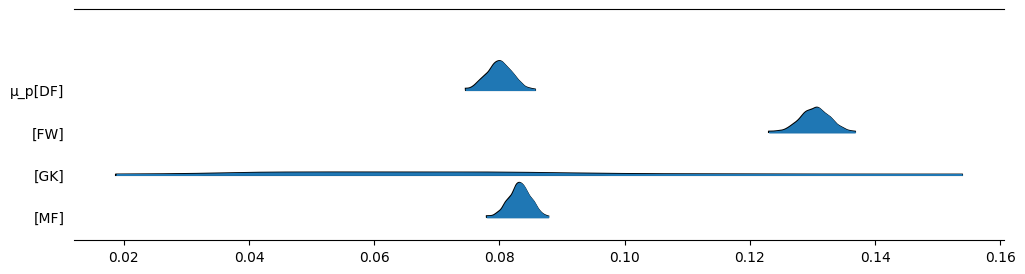

In [14]:
az.plot_forest(idata_sccr_nh, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)


The posteriors for the hierarchical and non-hierarchical models are quite similar. For positions besides goalkeeper, the curves look almost the same. Both models seem to have trouble with the goalkeeper position. The only real difference is that the hierarchical model's x-axis stops at 0.175, and the non-hierarchical model's stops at 0.200, but I'm not sure if that matters.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [15]:

sccr_data_new = pd.read_csv(url_sccr)
sccr_data_new = sccr_data_new.query('position != "GK"')
sccr_data_new['position'] = sccr_data_new['position'].astype('category')
sccr_data_new

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [ ]:
pos_idx_new = sccr_data_new.position.cat.codes.values
pos_codes_new = sccr_data_new.position.cat.categories
sccr_coords_new = {"pos": pos_codes_new}

with pm.Model(coords = sccr_coords_new) as sccr_model_h:
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")
    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")
    θ = pm.Beta('θ', mu = μ_p[pos_idx_new], nu = ν_p[pos_idx_new])
    _ = pm.Binomial('gs', n = sccr_data_new.shots.values, p = θ, observed = sccr_data_new.goals.values)
    idata_sccr_h = pm.sample(target_accept = 0.80)

Not really sure why I'm getting this error.

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.0 1.002 1.001 0.9997 ... 1.002 1.001 1.002
    μ        float64 8B 1.001
    μ_p      (pos) float64 24B 1.005 1.001 1.007
    ν        float64 8B 0.9999
    ν_p      (pos) float64 24B 1.024 1.006 1.028

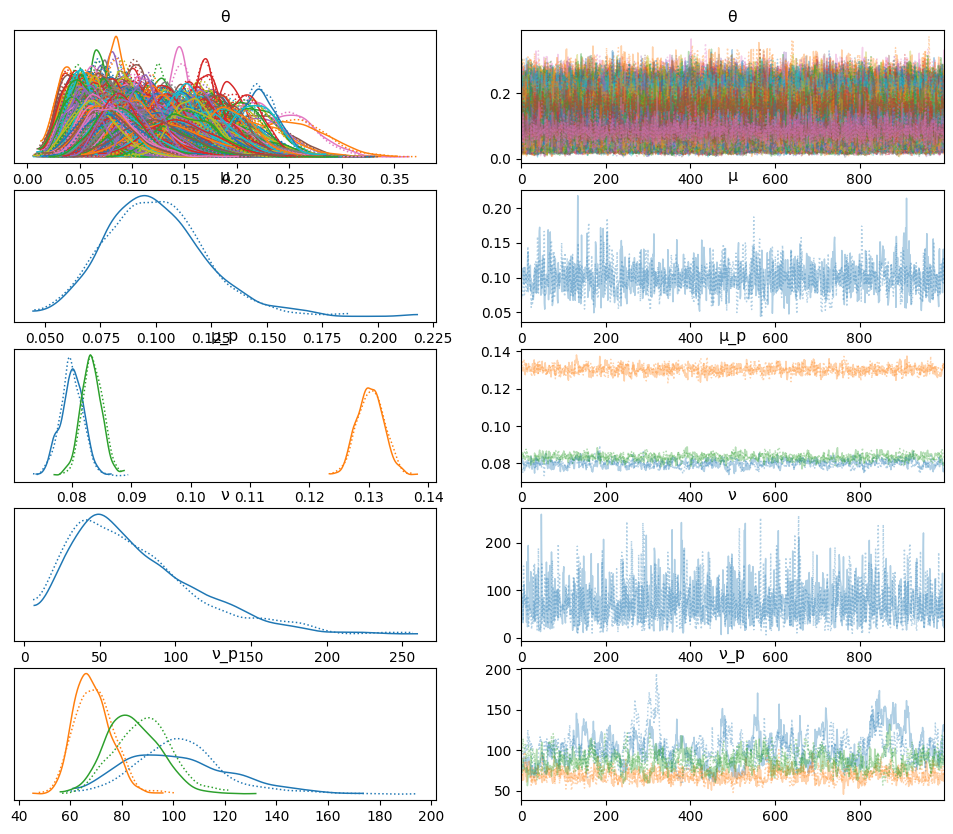

In [17]:
az.plot_trace(idata_sccr_h)
az.rhat(idata_sccr_h)


The hierarchical model without goalkeeper stats was much easier for pymc to run (it took half the time!). When we take out the goalkeeper stats, we lose some data, but the model works much better. The R-hat values are closer to 1, and the graphs for θ and ν_p are smoother.